In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Anomaly Detection of Infrastructure Logs using Gemini and BigQuery Vector Search

<table align="left">
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fgenerative-ai%2Fmain%2Fembeddings%2Fuse-cases%2Foutlier-detection%2Fbq-vector-search-outlier-detection-infra-logs.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Run in Colab Enterprise
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/embeddings/use-cases/outlier-detection/bq-vector-search-outlier-detection-infra-logs.ipynb">
      <img width="32px" src="https://www.gstatic.com/pantheon/images/bigquery/welcome_page/colab-logo.svg" alt="Google Colaboratory logo"><br> Run in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/embeddings/use-cases/outlier-detection/bq-vector-search-outlier-detection-infra-logs.ipynb">
      <img src="https://www.gstatic.com/images/branding/gcpiconscolors/vertexai/v1/32px.svg" alt="Vertex AI logo"><br> Open in Vertex AI Workbench
    </a>
  </td>
    <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/embeddings/use-cases/outlier-detection/bq-vector-search-outlier-detection-infra-logs.ipynb">
      <img width="32px" src="https://upload.wikimedia.org/wikipedia/commons/9/91/Octicons-mark-github.svg" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
</table>

| | |
|-|-|
| Author: | [Roy Arsan](https://github.com/rarsan) |

## Overview

This notebook guides you through processing large volumes of logs using Gemini, vector embeddings and [BigQuery Vector Search](https://cloud.google.com/bigquery/docs/vector-search-intro) to perform anomaly detection. We evaluate the accuracy using publicly available labelled [HDFS](https://github.com/logpai/loghub) dataset, and contrast it with other common log anomaly detection techniques.


As part of this notebook you will learn how to:
1. Use SQL for preprocessing raw logs at scale, interact with LLMs and do vector search analysis
1. Use Gemini 1.5 Flash to translate a log sequence into simple natural language summary directly from BigQuery
1. Use a text embedding model to generate a vector embedding for each log summary directly from BigQuery, and store all embeddings in BigQuery vector index for fast lookup
1. Tune and run vector search-based anomaly detection using BigQuery vector search
1. Evaluate performance and compare against popular unsupervised and semi-supervised outlier detection ML algorithms


This notebook demonstrates how using off-the-shelf Gemini 1.5 Flash + Text Embeddings + BigQuery vector search yields comparable results to custom pre-trained language models including DeepLog, an [LSTM deep neural network](https://dl.acm.org/doi/10.1145/3133956.3134015).

We also compare vector search-based outlier detection with common [scikit outlier detection](https://scikit-learn.org/stable/modules/outlier_detection.html#) algorithms (OneClassSVM, LocalOutlierFactor) using the same generated embeddings and we found that a custom SQL logic using BigQuery vector search to be more accurate and flexible for this use case and dataset.

For performance results, see `Summary` section at the bottom.

 You can use and tweak this notebook to evaluate for your own outlier detection use case, with your own dataset and target sensitivity level.

### Data pipeline

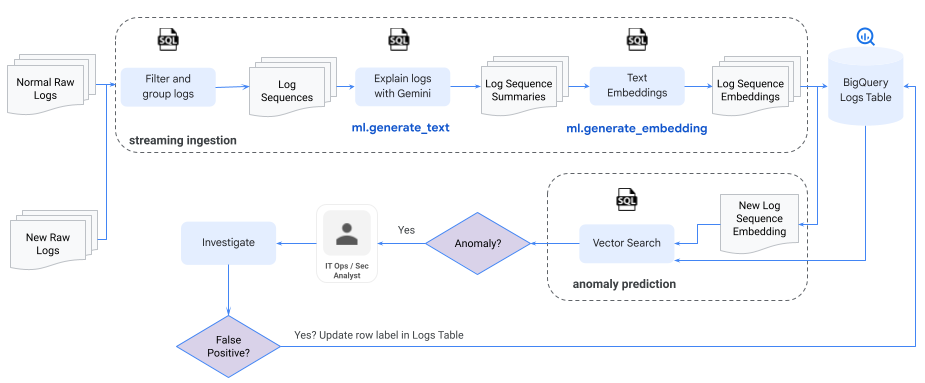

### Task, metrics and dataset

Outlier detection, specifically novelty detection, is about detecting all anomalies including 'unknown' types of anomalies (e.g. system failures, new cyberattacks, etc.). Therefore supervised approaches where you train the model on both normal and abnormal logs are simply not applicable. Therefore, the approach described in this notebook is compared against leading and popular unsupervised and semi-supervised techniques. **Recall** is our primary objective for outlier detection (minimize false negatives) while also keeping reasonably high **precision** (minimize false positives).

We use the open-source labelled HDFS dataset from [Loghub]((https://github.com/logpai/loghub) which is freely accessible and commonly used in log analysis evaluations, including anomaly detection. HDFS dataset provides 11M+ system log lines (\~575k log sessions) collected from a real Hadoop cluster on 200 nodes, and labelled by Hadoop domain experts to identify the runtime anomalies. For the purpose of this notebook, we use a subset of the HDFS dataset (\~60k log sessions or 10%) taking into consideration default BigQuery ML quota limits (e.g. 200 rpm and 72,000 rows per job with `gemini-1.5-flash` at the time of this writing). This way you can run this notebook as is in your own Google Cloud project in a timely fashion without necessarily requesting quota increases.


## Getting started

### Install Vertex AI SDK and other required packages


In [ ]:
%pip install --upgrade --user --quiet \
    google-cloud-aiplatform \
    google-cloud-bigquery \
    scikit-learn==1.3.1

### Restart runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which restarts the current kernel.

The restart might take a minute or longer. After it's restarted, continue to the next step.

In [ ]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Wait until it's finished before continuing to the next step. ⚠️</b>
</div>


### Authenticate your notebook environment (Colab only)

If you're running this notebook on Google Colab, run the cell below to authenticate your environment.

In [ ]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

### Set Google Cloud project information and initialize Vertex AI SDK

To get started using Vertex AI, you must have an existing Google Cloud project and [enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com).

Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).

In [ ]:
PROJECT_ID = "[project-id]"  # @param {type:"string"}
REGION = "us-central1"  # @param {type:"string"}
LOCATION = "US" # @param {type:"string"}

import vertexai

vertexai.init(project=PROJECT_ID, location=REGION)

### Import libraries

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from datetime import datetime
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

import bigframes.pandas as bpd
import bigframes.ml as bml

In [ ]:
# initialize bigquery client
client = bigquery.Client()

# initialize bigquery dataframes client
bpd.close_session()
bpd.options.bigquery.project = PROJECT_ID
bpd.options.bigquery.location = LOCATION

In [ ]:
DATASET = "vs_logs_demo"  # @param {type:"string"}

### Create a new dataset

In [ ]:
%%bigquery
CREATE SCHEMA `vs_logs_demo` OPTIONS (LOCATION = 'US');

### Create Cloud resource connection for Vertex AI

You need to create a Cloud resource connection to enable BigQuery to interact with Vertex AI services such as LLM remote models.

In [ ]:
CONNECTION_NAME = 'bq-llm-connection' # @param {type:"string"}

In [ ]:
!bq mk --connection --location={LOCATION} --project_id={PROJECT_ID} \
    --connection_type=CLOUD_RESOURCE {CONNECTION_NAME}

Retrieve the connection service account ID

In [ ]:
!bq show --connection {PROJECT_ID}.{LOCATION}.{CLOUD_RESOURCE_CONN}

Copy the service account ID in the following parameter:

In [ ]:
# Copy the value of `serviceAccountId` field in last cell's output
CONNECTION_SA_ID = "[bq-connection-service-account]"  # @param {type:"string"}

Give that service account access to Vertex AI

In [ ]:
!gcloud projects add-iam-policy-binding {PROJECT_ID} --member='serviceAccount:{CONNECTION_SA_ID}' --role='roles/aiplatform.user' --condition=None --no-user-output-enabled

If your notebook environment does not have `setIamPolicy` permission on the project, you (or your project's administrator) can alternatively grant  permissions to that cloud connection's service account using Cloud Console following these steps: https://cloud.google.com/bigquery/docs/generate-text-tutorial-gemini#grant-permissions

## Import logs dataset into BigQuery

The HDFS dataset was originally developed by Wei Xu et al. in [Detecting Large-Scale System Problems by Mining Console Logs](https://people.eecs.berkeley.edu/~jordan/papers/xu-etal-sosp09.pdf) and made available in [Wei Xu's website](https://people.iiis.tsinghua.edu.cn/~weixu/sospdata.html). The raw logs are also available at [loghub](https://github.com/logpai/loghub) thanks to the work of Zhu et al. in [Loghub: A Large Collection of System Log Datasets for AI-driven Log Analytics](https://arxiv.org/abs/2008.06448). To facilitate log ingestion and analysis in this notebook, the logs are expected to be converted to structured format (csv) using a standard log parser such as [this one](https://github.com/logpai/logparser/blob/main/logparser/Drain/README.md) from [logparser](https://github.com/logpai/logparser).

For the purpose of this notebook, the pre-parsed logs are available as .csv files in a GCS bucket:

*   Full dataset: `HDFS.log_structured.csv` (2.9 GB)
*   Limited 2k dataset: `HDFS_2k.log_structured.csv` (< 1 MB)

You will import the full dataset in this notebook, but subsequently process ~15% of the data.

### Load logs from GCS

In [ ]:
gcs_bucket = "gs://csa-datasets-public/hdfs"
gcs_filename = "HDFS.log_structured.csv" # @param {type:"string"}

gcs_uri = gcs_bucket + gcs_filename

def camelCase(col):
    return col[0].lower() + col[1:]

df = bpd.read_csv(gcs_uri, engine="bigquery")
# lowercase first letter of each column name
df.columns = [camelCase(col) for col in df.columns]
print(df.info())

df.to_gbq("vs_logs_demo.hdfs_full_structured", if_exists="replace")

### Group logs by sessions

Grouping logs by session ID or other unique identifiers allows us to correlate events that belong to the same user or transaction, providing context and a clear chronological sequence of actions. This is essential for understanding user behavior, troubleshooting issues, and identifying patterns that might otherwise be lost in the noise of a massive, undifferentiated log stream.

In our case, since HDFS logs are records of events related to file system operations at the block level, such as block replication and deletion, we need to group HDFS logs by unique `blockId`.

In [ ]:
%%bigquery
CREATE OR REPLACE TABLE `vs_logs_demo.hdfs_full_sessionized` AS (
  SELECT
    blockId,
    -- Capture start and end time
    MIN(timestamp) AS ts_start,
    MAX(timestamp) AS ts_end,
    COUNT(*) AS numEvents,
    -- Concatenate sequence of events
    STRING_AGG(CONCAT(
     component, " ", level, " ", content
    ), '\n' ORDER BY timestamp ASC) AS eventSequence,
    -- Concatenate sequence of event templates
    STRING_AGG(CONCAT(
     component, " ", level, " ", eventTemplate
    ), '\n' ORDER BY timestamp ASC) AS eventTemplateSequence,
    -- For debug only
    ARRAY_AGG(STRUCT(
        timestamp, level, component, content, eventId, eventTemplate
    ) ORDER BY timestamp ASC) AS sequence,
  FROM (
    SELECT
      PARSE_TIMESTAMP('%y%m%d %H%M%S', CONCAT(LPAD(CAST(date AS STRING), 6, '0'), ' ', LPAD(CAST(time AS STRING), 6, '0'))) AS timestamp,
      REGEXP_EXTRACT(content, r'(blk_-?[0-9]+)') AS blockId,
      * EXCEPT(date, time)
    FROM `vs_logs_demo.hdfs_full_structured`
  )
  GROUP BY
    blockId
  ORDER BY
    ts_start ASC, blockId ASC
);

### Label log sequences

This is a labelled dataset where each `blockId` has a binary label: either 'Normal' or 'Anomaly'. Let's retrieve the labels CSV file and store it in separate BigQuery table `hdfs_labels`.

In [ ]:
gcs_uri = "gs://csa-datasets-public/hdfs/anomaly_label.csv"
df_labels = bpd.read_csv(gcs_uri, engine="bigquery", header=0)
df_labels.columns = ['blockId', 'label']
print(df_labels.info())

df_labels.to_gbq("vs_logs_demo.hdfs_labels", if_exists="replace")

Let's correlate the log sequences with the labels table, and create a new labelled table for log sequences by setting a new boolean column `abnormal`. We also capture the sequential order of rows in `sessionId` which will come in handy later on for splitting the dataset and batching calls to Vertex AI API given its rate limits.

In [ ]:
%%bigquery
CREATE OR REPLACE TABLE `vs_logs_demo.hdfs_full_labelled` AS (
SELECT
  -- Capture sequential order of sessions
  ROW_NUMBER() OVER(ORDER BY logs.ts_start ASC) AS sessionId,
  logs.* EXCEPT(sequence),
  CASE
    WHEN labels.label = 'Anomaly' THEN TRUE
    ELSE FALSE
  END AS abnormal
FROM `vs_logs_demo.hdfs_full_sessionized` logs
LEFT JOIN `vs_logs_demo.hdfs_labels` labels USING (blockId)
)


### Exploratory data analysis

In [ ]:
df = bpd.read_gbq("vs_logs_demo.hdfs_full_labelled")
df.shape

In [ ]:
df.head(5)

Let's see the distribution of log sequence length, by displaying summary stats for `numEvents` numeric column

In [ ]:
df.describe()

Let's the sample the data and get a breakdown of lengths of log sequences

In [ ]:
bpd.options.sampling.enable_downsampling = True # enable downsampling
bpd.options.sampling.max_download_size = 200 # download only 200 mb of data

In [ ]:
local_df = df.to_pandas(max_download_size=200, sampling_method="uniform", random_state=101)

<Axes: xlabel='abnormal', ylabel='count'>

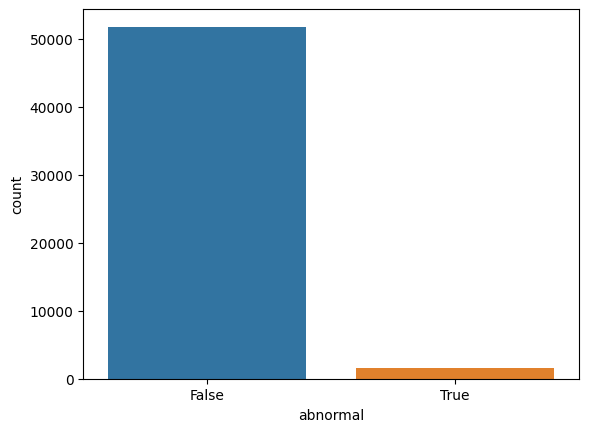

In [ ]:
sns.countplot(x = "abnormal", data=local_df)

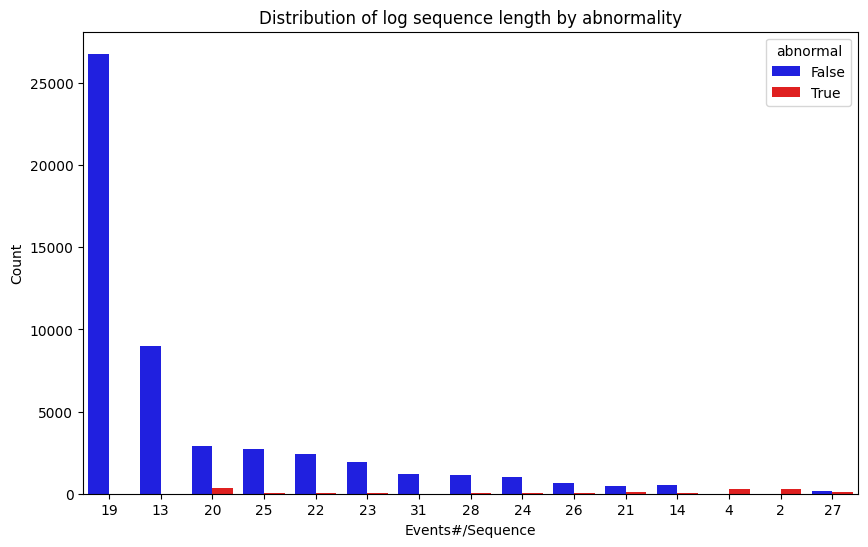

In [ ]:
plt.figure(figsize=(10, 6))

# Plot with Seaborn (hue creates separate bars for each boolean value)
sns.countplot(data=local_df, x='numEvents', hue='abnormal', palette=['blue', 'red'],
              order=local_df['numEvents'].value_counts().iloc[:15].index)
plt.title('Distribution of log sequence length by abnormality')
plt.xlabel('Events#/Sequence')
plt.ylabel('Count')
plt.show()

## Create and store embeddings in vector index

### Explain log sequences
Prompt Gemini 1.5 Flash to translate log sequences into natural language

#### Create the remote model for Gemini 1.5 Flash in BigQuery

In [ ]:
%%bigquery
CREATE OR REPLACE MODEL `vs_logs_demo.gemini_1_5_flash`
REMOTE WITH CONNECTION `us.llm_textembedding_connection`
OPTIONS (endpoint = 'gemini-1.5-flash-001')

#### Prepare prompt

In [ ]:
# Prompt for Gemini
prompt_prefix = f"""\
You're an IT expert and administrator of a Hadoop Distributed File System or HDFS cluster.
You are provided with a sequence of HDFS logs in chronological order, where each log line contains the log source component, followed by the log severity and the log content itself.
Describe succinctly in plain english the events corresponding to this sequence of logs.
Do not repeat the raw logs in your explanation. Do not speculate, explain or make stuff up.
Be concise in your answer and combine similar events together.
Output must be formatted as an ordered numbered list and without any preamble.
"""

# One-shot example where the input is the raw log sequence for one session,
# and the output is the corresponding log explanation in natural language.
example_input = f"""\
dfs.DataNode$DataXceiver INFO Receiving block blk_4970672161979262840 src: /10.251.111.130:54916 dest: /10.251.111.130:50010
dfs.FSNamesystem INFO BLOCK* NameSystem.allocateBlock: /user/root/rand5/_temporary/_task_200811101024_0011_m_000844_0/part-00844. blk_4970672161979262840
dfs.DataNode$DataXceiver INFO Receiving block blk_4970672161979262840 src: /10.251.66.102:49145 dest: /10.251.66.102:50010
dfs.DataNode$DataXceiver INFO Receiving block blk_4970672161979262840 src: /10.251.111.130:34614 dest: /10.251.111.130:50010
dfs.DataNode$PacketResponder INFO PacketResponder 1 for block blk_4970672161979262840 terminating
dfs.DataNode$PacketResponder INFO PacketResponder 0 for block blk_4970672161979262840 terminating
dfs.DataNode$PacketResponder INFO PacketResponder 2 for block blk_4970672161979262840 terminating
dfs.DataNode$PacketResponder INFO Received block blk_4970672161979262840 of size 67108864 from /10.251.111.130
dfs.FSNamesystem INFO BLOCK* NameSystem.addStoredBlock: blockMap updated: 10.251.111.130:50010 is added to blk_4970672161979262840 size 67108864
dfs.FSNamesystem INFO BLOCK* NameSystem.addStoredBlock: blockMap updated: 10.251.66.102:50010 is added to blk_4970672161979262840 size 67108864
dfs.DataNode$PacketResponder INFO Received block blk_4970672161979262840 of size 67108864 from /10.251.66.102
dfs.DataNode$PacketResponder INFO Received block blk_4970672161979262840 of size 67108864 from /10.251.111.130
dfs.FSNamesystem WARN BLOCK* NameSystem.addStoredBlock: Redundant addStoredBlock request received for blk_4970672161979262840 on 10.251.194.147:50010 size 67108864
dfs.FSNamesystem INFO BLOCK* NameSystem.addStoredBlock: blockMap updated: 10.251.194.147:50010 is added to blk_4970672161979262840 size 67108864
dfs.FSNamesystem INFO BLOCK* NameSystem.delete: blk_4970672161979262840 is added to invalidSet of 10.251.66.102:50010
dfs.FSNamesystem INFO BLOCK* NameSystem.delete: blk_4970672161979262840 is added to invalidSet of 10.251.111.130:50010
dfs.FSNamesystem INFO BLOCK* NameSystem.delete: blk_4970672161979262840 is added to invalidSet of 10.251.194.147:50010
dfs.FSDataset INFO Deleting block blk_4970672161979262840 file /mnt/hadoop/dfs/data/current/subdir59/blk_4970672161979262840
dfs.FSDataset INFO Deleting block blk_4970672161979262840 file /mnt/hadoop/dfs/data/current/subdir9/blk_4970672161979262840
dfs.FSDataset INFO Deleting block blk_4970672161979262840 file /mnt/hadoop/dfs/data/current/subdir31/blk_4970672161979262840
"""

example_output = f"""\
1. The NameNode allocates a new block for a file in the user directory.
2. Three DataNodes are receiving the block.
3. The DataNodes packet responders for that block are terminating.
4. The DataNodes receives the block.
5. The NameNode updates block map after receiving confirmation that the block has been received by the three DataNodes.
6. The NameNode reports a warning that it received a redundant confirmation from one of the DataNodes.
7. The NameNode deletes the block and marks it as invalid on all three DataNodes.
8. The DataNodes delete the block from their local storage.
"""

# Escape newlines before subsequent use in f-strings
prompt_prefix = prompt_prefix.replace('\n', '\\n')
example_input = example_input.replace('\n', '\\n')
example_output = example_output.replace('\n', '\\n')

params = {
  'prompt_prefix': prompt_prefix,
  'example_input': example_input,
  'example_output': example_output,
}

In [ ]:
sql = f"""\
CREATE OR REPLACE TABLE `vs_logs_demo.hdfs_prompts` AS (
  SELECT * FROM UNNEST([STRUCT(
    'Explain HDFS log sequences' AS task,
    "{prompt_prefix}" AS prompt_prefix,
    "{example_input}" AS example_input,
    "{example_output}" AS example_output
  )])
);
"""

query_job = client.query(sql)
print(query_job.result())  # Wait for the job to complete.
print(f"Created Table {PROJECT_ID}.vs_logs_demo.hdfs_prompts")

Let's save the prompt and one-shot example in a new BigQuery table `hdfs_prompt`

In [ ]:
%%bigquery --params {"prompt_prefix": prompt_prefix, "example_input": example_input, "example_output": example_output}
CREATE OR REPLACE TABLE `vs_logs_demo.hdfs_prompt` AS (
  SELECT prompt AS @prompt_prefix
)

As an example, let's take the following 'normal' raw log sequence for specific blockID `blk_-3750780870143089898`:

In [ ]:
dfs.DataNode$DataXceiver INFO Receiving block blk_-3750780870143089898 src: /10.251.67.211:46933 dest: /10.251.67.211:50010
dfs.FSNamesystem INFO BLOCK* NameSystem.allocateBlock: /user/root/randtxt5/_temporary/_task_200811101024_0012_m_000993_0/part-00993. blk_-3750780870143089898
dfs.DataNode$DataXceiver INFO Receiving block blk_-3750780870143089898 src: /10.251.42.207:51200 dest: /10.251.42.207:50010
dfs.DataNode$DataXceiver INFO Receiving block blk_-3750780870143089898 src: /10.251.67.211:50346 dest: /10.251.67.211:50010
dfs.DataNode$PacketResponder INFO PacketResponder 0 for block blk_-3750780870143089898 terminating
dfs.DataNode$PacketResponder INFO PacketResponder 2 for block blk_-3750780870143089898 terminating
dfs.FSNamesystem INFO BLOCK* NameSystem.addStoredBlock: blockMap updated: 10.251.42.207:50010 is added to blk_-3750780870143089898 size 67108864
dfs.FSNamesystem INFO BLOCK* NameSystem.addStoredBlock: blockMap updated: 10.251.67.211:50010 is added to blk_-3750780870143089898 size 67108864
dfs.DataNode$PacketResponder INFO Received block blk_-3750780870143089898 of size 67108864 from /10.251.67.211
dfs.FSNamesystem INFO BLOCK* NameSystem.addStoredBlock: blockMap updated: 10.251.194.129:50010 is added to blk_-3750780870143089898 size 67108864
dfs.DataNode$PacketResponder INFO PacketResponder 1 for block blk_-3750780870143089898 terminating
dfs.DataNode$PacketResponder INFO Received block blk_-3750780870143089898 of size 67108864 from /10.251.67.211
dfs.DataNode$PacketResponder INFO Received block blk_-3750780870143089898 of size 67108864 from /10.251.42.207
dfs.FSNamesystem INFO BLOCK* NameSystem.delete: blk_-3750780870143089898 is added to invalidSet of 10.251.42.207:50010
dfs.FSNamesystem INFO BLOCK* NameSystem.delete: blk_-3750780870143089898 is added to invalidSet of 10.251.67.211:50010
dfs.FSNamesystem INFO BLOCK* NameSystem.delete: blk_-3750780870143089898 is added to invalidSet of 10.251.194.129:50010
dfs.FSNamesystem INFO BLOCK* ask 10.251.194.129:50010 to delete  blk_-3750780870143089898 blk_8839488796462659348 blk_-1076638448786103147 blk_-2607303556568476338 blk_-872077376619694315 blk_3658484321727696675 blk_-8783295298979970351 blk_7253228695508151434 blk_8353593257930202451 blk_6896918372378359715 blk_8476431461885450664 blk_-453468701147780383 blk_2747276825479054342 blk_7831811674826419739 blk_-4676554322964835078 blk_838168686993939059 blk_-3667727247990911503 blk_554950885642981306 blk_3690236354878191248 blk_3594952792786303214 blk_710500522210229744 blk_-641656950218902981 blk_-8914315030958124984 blk_8473337661129085162 blk_8747565120239750968 blk_8483881408521191191 blk_970871787748196992 blk_-1238776083272375823 blk_-4355328787228390393 blk_-6232254141637974415 blk_2851445563013723058 blk_4729371515425302371 blk_-8138185632733985405 blk_3530286662170963267 blk_6705596331043244121 blk_5856355648225187587 blk_-5271003563714979606 blk_6099159980310485523 blk_5770736739131705773 blk_-4630334698677080743 blk_-316813592070079363 blk_-8376103172399604209 blk_-5004999163141797571 blk_-1184480050082523451 blk_-8644451221914479826 blk_-4421425625682059690 blk_8309579147878024429 blk_3172294788463323663 blk_-426829215056729544 blk_-785413567218674273 blk_2115841663373157801 blk_2855785622370264073 blk_8386172561326404060 blk_6747728035734009764 blk_7206820189825343828 blk_9222274141331127342 blk_-7791132919862479353 blk_-1813922770106404412 blk_-6794746648243431237 blk_-3114372317175128819 blk_-5375459594742433201 blk_6912573532770191892 blk_124792821150689426 blk_8787609558519171611 blk_-5450607639120667562 blk_769133640763536215 blk_4689006757714287009 blk_-2322954586860795404 blk_-3083400559019231217 blk_-2398840409229247956 blk_4606567481735284177 blk_-1098865217826643562 blk_-3075042532557633130 blk_6737487517130970246 blk_3299232526334609785 blk_-1866148958272946201 blk_4803758272177687030 blk_2068490022276187676 blk_-4724682685867818017 blk_-1311156078103024510 blk_-1781420834572645132 blk_-8680808247265383818 blk_7865294689332645011 blk_-7864388093305159311 blk_-7259235578951211339 blk_4437793449639312068 blk_2972756848238658967 blk_160665971665268866 blk_7862577900146719312 blk_2141823066215925124 blk_4044494381360076828 blk_868975602193282101 blk_-8493544210473294093 blk_-3909434520726038447 blk_-2397800658299122228 blk_-6929912433144478107 blk_-2022835339724037507 blk_-251514397381670680 blk_-4491187364929180193 blk_-4766279731310845414
dfs.FSDataset INFO Deleting block blk_-3750780870143089898 file /mnt/hadoop/dfs/data/current/subdir32/blk_-3750780870143089898
dfs.FSDataset INFO Deleting block blk_-3750780870143089898 file /mnt/hadoop/dfs/data/current/subdir16/blk_-3750780870143089898
dfs.FSDataset INFO Deleting block blk_-3750780870143089898 file /mnt/hadoop/dfs/data/current/subdir55/blk_-3750780870143089898


The Gemini prompt above converts those raw log entries into a sequence of events in natural language which captures concisely the execution path including detailed semantics information while excluding specific identifiers:

```
1. The NameNode allocates a new block for a file in the user directory.
2. Three DataNodes are receiving the block.
3. The NameNode updates block map after receiving confirmation that the block has been received by the three DataNodes.
4. The NameNode asks one of the DataNodes to delete the block.
5. The DataNodes delete the block from their local storage.
```

#### Run on subset of logs

The following **may take 5 hours or less** depending on your Vertex AI quota of requests per minute for `gemini-1.5-flash` base model. The following query goes over a small subset of the dataset: 60k log sequences will be translated into natural language summary. At the time of this writing, the default rate limit for `gemini-1.5-flash` in `us-central1` region is **200 requests/min**. To speed up this step, you can optionally [request quota increase](https://cloud.google.com/vertex-ai/generative-ai/docs/quotas#view-quotas-in-console) for Vertex AI endpoint for `gemini-1.5-flash` for your specific region and project. If you do increase that Vertex AI quota, send an email to bqml-feedback@google.com to adjust and increase your BigQuery ML quota for `ML.GENERATE_TEXT` calls to that base model, since BigQuery ML rate-limits the calls to Vertex AI endpoint accordingly.

The following SQL code firsts create the table `hdfs_full_explained`, then creates a procedure to generate content from Gemini and inserts into the destination table. You call the procedure iteratively to process data in batches and avoid losing processed results due to runtime error like query timeout or quota exhaustion, both of which are unlikely with smaller batches.

In [ ]:
%%bigquery
CREATE OR REPLACE TABLE `vs_logs_demo.hdfs_full_explained`
(
  sessionId INT64,
  blockId STRING,
  abnormal BOOL,
  numEvents INT64,
  eventSequence STRING,
  eventTemplateSequence STRING,
  status STRING,
  response STRING,
  input_tokens INT64,
  output_tokens INT64,
  total_token_count INT64
)
PARTITION BY RANGE_BUCKET(sessionId, GENERATE_ARRAY(0, 600000, 10000))
CLUSTER BY abnormal, numEvents;

In [ ]:
params['prompt_prefix']

In [ ]:
%%bigquery
CREATE OR REPLACE PROCEDURE `vs_logs_demo.explain_hdfs_logs_test`(
  start_row INT64,
  batch_size INT64
)
BEGIN
  INSERT INTO `vs_logs_demo.hdfs_full_explained`
  SELECT
    sessionId, blockId, abnormal, numEvents, eventSequence, eventTemplateSequence,
    ml_generate_text_status AS status,
    LAX_STRING(ml_generate_text_result.candidates[0].content.parts[0].text) AS response,
    LAX_INT64(ml_generate_text_result.usage_metadata.prompt_token_count) AS input_tokens,
    LAX_INT64(ml_generate_text_result.usage_metadata.candidates_token_count) AS output_tokens,
    LAX_INT64(ml_generate_text_result.usage_metadata.total_token_count) AS total_token_count
  FROM
    ML.GENERATE_TEXT(
      MODEL `vs_logs_demo.gemini_1_5_flash`,
      (
        SELECT
          -- A prompt for HDFS logs explanation with one-shot example.
          sessionId, blockId, abnormal, numEvents, eventSequence, eventTemplateSequence,
          CONCAT(llm.prompt_prefix,
            "Here is one-shot example:\n",
            "Log sequence:\n", llm.example_input,
            "Log sequence summary:\n", llm.example_output,
            "Here is the input:\n",
            "Log sequence: ", eventSequence, "\n",
            "Answer: "
        ) AS prompt
        FROM `vs_logs_demo.hdfs_full_labelled`, `vs_logs_demo.hdfs_prompts` AS llm
        WHERE
          llm.task = "Explain HDFS log sequences"
          AND sessionId BETWEEN start_row AND start_row + batch_size -1
      ),
      STRUCT(
        0.2 AS temperature,
        2048 AS max_output_tokens, -- limit response to ~1400 words
        FALSE AS flatten_json_output
      )
    );
END;

In [ ]:
%%bigquery
-- Call procedure with batches of 20,000 to stay well within #rows/job quota
-- for ML.GENERATE_TEXT (72k with Gemini 1.5 Flash, 21.6k with Gemini 1.5 Pro)
-- https://cloud.google.com/bigquery/quotas#cloud_ai_service_functions
BEGIN
  CALL `vs_logs_demo.explain_hdfs_logs`(1, 20000);
  CALL `vs_logs_demo.explain_hdfs_logs`(20001, 40000);
  CALL `vs_logs_demo.explain_hdfs_logs`(40001, 60000);
END;


To process even larger datasets, you can use the procedure iteratively  sequentially while accounting for the quota limit of 72k rows per job.
Note the cumulative time limit for a multi-statement query in BigQuery is 24 hours. If the above code times out (unlikely with small 20k batches for a total of 60k), simply comment out the successfully completed batches before running it again so it can resume after that batch.

### Generate embeddings for log sequences

#### Create the remote model for generating text embeddings

In [ ]:
%%bigquery
CREATE OR REPLACE MODEL `vs_logs_demo.text_embedding`
REMOTE WITH CONNECTION `us.llm_textembedding_connection`
OPTIONS (endpoint = 'text-embedding-004')

#### Generate embeddings

Let's generate vector embedding for each log sequence to capture the semantic meaning of the Gemini-produced sequence of operations over each `blockId`.

The following **will take several minutes** depending on your quota of requests per minute for `text-embedding` base model. At the time of this writing, the default rate limit for `text-embedding` in `us-central1` region is 1500 requests/min.

The following query processes the entire `hdfs_full_explained` table. Unlike the previous section, where `ML.GENERATE_TEXT` was run in iterative batches, we run `ML.GENERATE_TEXT_EMBEDDING` as one job given the higher limit of 2,700,000 rows per job, that is well above our dataset of 60,000 session records.


**Important Note:** we use `CLUSTERING` embedding task type which is best suited for (clustering-based) anomaly detection task, as opposed to other tasks like document retrieval (RAG) or semantic similarity search.

In [ ]:
%%bigquery
CREATE OR REPLACE TABLE `vs_logs_demo.hdfs_full_embeddings` AS (
  SELECT
    * EXCEPT(ml_generate_embedding_result, ml_generate_embedding_status, ml_generate_embedding_statistics),
    ml_generate_embedding_status AS status,
    LAX_INT64(ml_generate_embedding_statistics.token_count) AS token_count,
    LAX_BOOL(ml_generate_embedding_statistics.truncated) AS truncated,
    ml_generate_embedding_result AS embeddings
  FROM
    ML.GENERATE_EMBEDDING(
      MODEL `vs_logs_demo.text_embedding`,
      (
        SELECT
          # sessionId, timeInterval, numEvents, sequence, abnormal,
          sessionId, blockId, abnormal, numEvents, eventSequence, eventTemplateSequence,
          response as content
        FROM `vs_logs_demo.hdfs_full_explained`
        -- skip records where previous ml.generate_text step failed due to quota exhaustion
        WHERE status=""
        ORDER BY sessionId ASC
        LIMIT 60000
      ),
      STRUCT(
          TRUE AS flatten_json_output,
          'CLUSTERING' as task_type
      )
    )
)
PARTITION BY RANGE_BUCKET(sessionId, GENERATE_ARRAY(0, 600000, 10000))
CLUSTER BY abnormal, numEvents;

### Create vector index

In [ ]:
%%bigquery
CREATE VECTOR INDEX index_treeah_1000 ON `vs_logs_demo.hdfs_full_embeddings`(embeddings)
# STORING (abnormal, sessionId, numEvents)
OPTIONS (index_type = 'TREE_AH',
  distance_type = 'COSINE',
  tree_ah_options = '{"leaf_node_embedding_count": 1000}');

Inspect vector index progress, and total storage (chargeable) from INFORMATION_SCHEMA.VECTOR_INDEXES view:

In [ ]:
%%bigquery
SELECT
  table_name,
  index_name,
  coverage_percentage,
  unindexed_row_count,
  last_refresh_time,
  total_logical_bytes,
  total_storage_bytes
FROM `vs_logs_demo.INFORMATION_SCHEMA.VECTOR_INDEXES`
WHERE index_status = 'ACTIVE';

## Visualize clusters of log sequences

As log sequences are projected into the 768-dimension vector space, similar log sequences are clustered as "neighbors" in the sense they share a similar sequence of what actually occurred.

Let's do a first-order evaluation to see how the clustering is performing qualitatively. Specifically, we're looking at how well-defined the clusters are and how much separation there is between clusters.

We use dimensionality reduction for visualizing in 2D space the clusters of HDFS log sequences embeddings by going from 768 to 2 dimension vectors.

### Visualize embeddings

In [ ]:
client = bigquery.Client()

# sql = f"""
# SELECT *
# FROM `vs_logs_demo.hdfs_full_embeddings`
# TABLESAMPLE SYSTEM (10 PERCENT)
# """
# df = client.query(sql).to_dataframe()

table_id = 'vs_logs_demo.hdfs_full_embeddings'
df = client.list_rows(table_id).to_dataframe()
df.head(2)

,sessionId,blockId,abnormal,numEvents,eventSequence,eventTemplateSequence,content,status,token_count,truncated,embeddings
0,119899,blk_-9060541879596316494,True,2,dfs.DataNode$DataXceiver INFO Receiving block ...,dfs.DataNode$DataXceiver INFO Receiving block ...,1. The NameNode allocates a new block for a fi...,,30,False,"[0.02920735441148281, 0.04813070967793465, -0...."
1,17072,blk_8929107803467731944,True,2,dfs.DataNode$DataXceiver INFO Receiving block ...,dfs.DataNode$DataXceiver INFO Receiving block ...,1. The NameNode allocates a new block for a fi...,,30,False,"[0.02920735441148281, 0.04813070967793465, -0...."


In [ ]:
print(df.iloc[70].content)

1. A block with ID blk_7780858808264270321 was allocated by the NameNode.
2. Three DataNodes received the block from different sources.
3. The NameNode recorded that the block was stored on three DataNodes.
4. The NameNode instructed the three DataNodes to delete the block.
5. The three DataNodes deleted the block from their local storage. 



In [ ]:
# Reduce dimensionality using t-SNE. Will take 5 minutes with 10% of the data
tsne = TSNE(n_components=2, random_state=0)
embeddings_array = np.array(df["embeddings"].to_list(), dtype=np.float32)
embeddings_2d = tsne.fit_transform(embeddings_array)

In [ ]:
# Mapping boolean values to colors
color_map = {True: 'red', False: 'blue'}
colors = df['abnormal'].map(color_map)

# Create a scatter plot of the embeddings
plt.figure(figsize=(10, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors, s=25, alpha=0.7)

plt.title('Log Embeddings Clusters')
plt.xlabel('TSNE-1')
plt.ylabel('TSNE-2')
plt.show()

Results should be rendered in a scatter plot as follows:

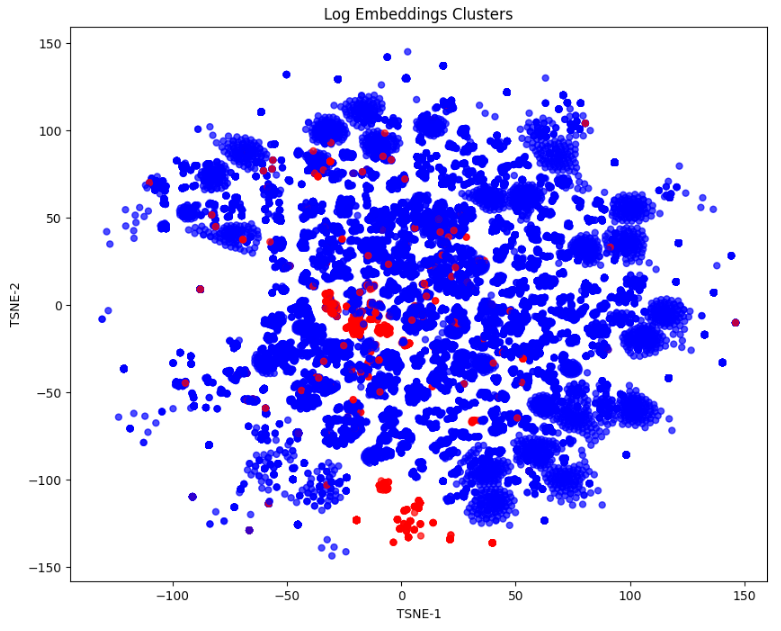

We can visually see many blue clusters (30-50), depicting different normal types of log sequences. The red dots are the abnormal log sequences that ultimately should be identified as outliers. While many of the red dots are clustered together, some are scattered and at the periphery of blue clusters.

## Detect outliers with BigQuery vector search

Let's implement a simple outlier detection logic leveraging BQ built-in optimized vector search using simple SQL.

### Split dataset into training and test

First, let's split the dataset into training and test datasets in BigQuery.

We use a session cutoff to split the first 50,000 sessions (ordered chronologically) to use for 'training' and then a subsequent 20,000 sessions for testing. Since this is semi-supervised learning on the negative class only (normal logs), we use only the normal logs sequences in the first 50,000 sessions.

In the context of BigQuery vector search, the vector index uses a k-means algorithm to cluster these records as they are ingested. That process is managed by BigQuery during and after index creation. We still writing the training and test dataset in separate table to facilitate testing of other ML models in subsequent section.

In [ ]:
session_id_cutoff = 50000 # Split train and eval datasets
num_sessions = 20000      # Number of sessions to use for testing

Retrieve and write test and training datasets in separate tables

In [ ]:
# Train dataset
sql = f"""
SELECT * FROM `vs_logs_demo.hdfs_full_embeddings`
WHERE
  abnormal=FALSE
  AND sessionId <= {session_id_cutoff}
"""
y_train = bpd.read_gbq(sql, index_col="sessionId")

# Persist the train dataset in a separate table to be used later for other models e.g. scikit-learn algor
y_train.to_gbq("vs_logs_demo.hdfs_full_embeddings_train", if_exists="replace")

# Test dataset
sql = f"""
SELECT
  sessionId, blockId, embeddings,
  CAST(abnormal AS INT64) AS label
FROM `vs_logs_demo.hdfs_full_embeddings`
WHERE sessionId > {session_id_cutoff}
ORDER BY sessionId ASC
LIMIT {num_sessions}
"""
y_test = bpd.read_gbq(sql, index_col="sessionId")

# Persist the test dataset in a separate table to be used several times with different vector search configurations
y_test.to_gbq("vs_logs_demo.hdfs_full_embeddings_test", if_exists="replace")

### Predict anomalies with vector search

The premise behind outlier detection is to identify log sequences that do not belong to any known 'normal' blue clusters. Given a log sequence test vector, if there is a sufficient number of 'normal' neighboring base vectors within a certain distance, then that log sequence is considered 'normal'. Otherwise, it is considered an outlier or an anomaly.

 To get the best performance in terms of outlier detection, the following procedure uses a brute force search to maximize recall of top-k closest 'normal' neighbors for every query vector.

In [ ]:
def predict_anomalies(n_neighbors, distance_threshold):
    sql = f"""
    SELECT
      query.blockId AS blockId,
      ANY_VALUE(query.sessionId) AS sessionId,
      COUNTIF(distance < {distance_threshold}) AS similar_normal_instances,
      IF(COUNTIF(distance < {distance_threshold}) >= {n_neighbors}, 0, 1) as predicted
    FROM VECTOR_SEARCH(
      (SELECT * FROM `vs_logs_demo.hdfs_full_embeddings` WHERE abnormal=FALSE AND sessionId <= {session_id_cutoff}), # TreeAH index
      'embeddings',
      TABLE `vs_logs_demo.hdfs_full_embeddings_test`,
      --(SELECT blockId, sessionId, embeddings FROM `vs_logs_demo.hdfs_full_embeddings` WHERE sessionId > {session_id_cutoff} ORDER BY sessionId ASC LIMIT {num_sessions}),
      top_k => {n_neighbors}, # Increase top_k value to 3x if using TreeAH with post-filtering
      distance_type => 'COSINE',
      options => '{{"use_brute_force":true}}'
      --options => '{{"fraction_lists_to_search":0.1}}'
    )
    GROUP BY
      query.blockId
    """
    return bpd.read_gbq(sql, index_col="sessionId")

**Note**: While the above procedure runs a brute force job for best outlier detection performance, you can still experiment with using the vector index by setting `fraction_lists_to_search` to optimize speed and cost while trading off some recall. For example, you could set it to 0.1 to only search only 10% of the clusters, those with the closest centroids, thereby reducing total latency and slot usage. Since we're using a TreeAH index, the prefilters on the base table are treated as post-filters and may reduce the top-k result set. In that case, make sure to multiply top_k value by say 3x to have a sufficient result set post-filtering.

Let's run the batch prediction: this will compare 20,000 test records against 47,770 'normal' base records, essentially doing 955 Millions distance calculations of 768-dimentional vectors. The following completes in **only 1 minute** given the small base table and sufficient parallel shards.

In [ ]:
n_neighbors = 10         # Number of neighbors to compare with
dist_threshold = 0.004;  # Neighbor within this distance is a match

# Batch predict on the test set
y_pred = predict_anomalies(n_neighbors, dist_threshold)

Let's see how much data was processed and the total time it took to predict anomalies across 20,000 test records. Replace `insert-job-id` with the BigQuery job ID returned in the last cell output.

In [ ]:
vs_job_id = '[insert-job-id]'

client = bigquery.Client()
job = client.get_job(vs_job_id)

print(f"Job ID: {vs_job_id}")
print(f"Total Bytes Processed: {round(job.total_bytes_processed / (1024 * 1024) , 2) } MB")
print(f"Slot-hours Used: {round(job.slot_millis / (1000 * 60 * 60), 2)}")

start_time = job.started
end_time = job.ended
execution_time = (end_time - start_time).total_seconds()
print(f"Query Execution Time: {execution_time:.2f} seconds")

Job ID: 199dd3dc-10fe-4ca1-b81c-386b21283a55
Total Bytes Processed: 938.72 MB
Slot-hours Used: 1.58
Query Execution Time: 6.67 seconds


Make sure the predicted result set `y_pred` is of the same size as the test dataset `y_test`, that is 20,000 records:

In [ ]:
print(y_test.shape)
print(y_pred.shape)

(20000, 3)
(20000, 3)


### Evaluate performance

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

In [ ]:
cnf_matrix = confusion_matrix(y_test['label'].to_pandas(), y_pred['predicted'].to_pandas())
print(cnf_matrix)

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=['normal', 'abnormal'])
disp.plot()
plt.show()

You should see the following confusion matrix rendered:

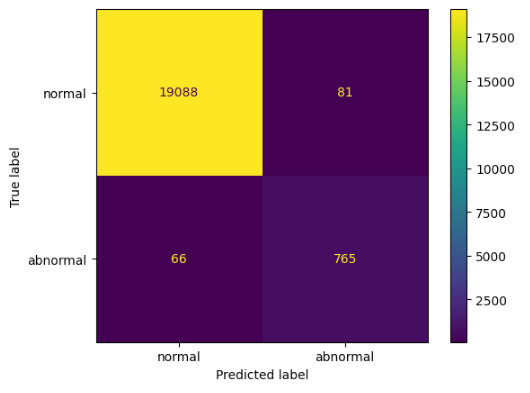

In [ ]:
target_names = ['normal', 'abnormal']
report = classification_report(y_test['label'].to_pandas(), y_pred['predicted'].to_pandas(), target_names=target_names)
print('Classification Report:\n', report)

You should observe the following classification metrics:

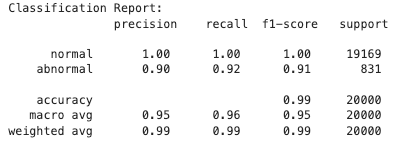    

In particular, results for 'abnormal' show 92% recall and 90% precision:

|  | precision |   recall | f1-score | support |
|---|---|---|---|---|
| normal    |   1.00   |   1.00  |    1.00   |  19169 |
| abnormal    |   0.90    |  0.92  |    0.91   |    831 |

#### Grid search to tune hyper-parameters



In [ ]:
from sklearn.metrics import f1_score, recall_score, precision_score

# Define the parameter grid for BQ vector search (adjust values as needed)
param_grid = {
    'n_neighbors': [6, 10, 12, 15],      # Number of neighbors to consider
    'dist_threshold': [0.004, 0.006, 0.008, 0.01], # Distance threshold for a match
}

# Initialize variables to track the best score and parameters
best_f1 = 0
best_recall = 0
best_params = {}

y_test_pd = y_test['label'].to_pandas()

# Manually iterate through parameter combinations
for n_neighbors in param_grid['n_neighbors']:
    for dist_threshold in param_grid['dist_threshold']:
        # No need to train any model - simply do a vector search

        # Make predictions on the test set
        y_pred_df = predict_anomalies(n_neighbors, dist_threshold)
        y_pred_pd = y_pred_df['predicted'].to_pandas()

        # Calculate F1-score
        f1 = f1_score(y_test_pd, y_pred_pd)
        # Calculate Recall
        recall = recall_score(y_test_pd, y_pred_pd)
        # Calculate Precision
        precision = precision_score(y_test_pd, y_pred_pd)

        # Update f1 score and parameters if current combination is better
        if f1 > best_f1:
            best_f1 = f1
            best_params = {'n_neighbors': n_neighbors, 'dist_threshold': dist_threshold}

        print(f"Parameters: n_neighbors={n_neighbors}, dist_threshold={dist_threshold}, Recall: {recall}, Precision: {precision}, F1-Score: {f1}")

# Print the best parameters and score
print("Best Parameters:", best_params)
print("Best F1-Score:", best_f1)

## Detect outliers with scikit-learn algorithms

As a baseline comparison, we'll evaluate popular [outlier detection algorithms](https://scikit-learn.org/stable/modules/outlier_detection.html#overview-of-outlier-detection-methods) implemented in scikit-learn, using the same logs embeddings that were generated and stored in BigQuery. [One-Class SVM](https://scikit-learn.org/stable/modules/outlier_detection.html#novelty-detection) and [Local Outlier Factor](https://scikit-learn.org/stable/modules/outlier_detection.html#novelty-detection-with-local-outlier-factor) are both semi-supervised learning methods suitable for novelty detection, and are available in the `svm` and `neighbors` modules respectively:

In [ ]:
from sklearn import svm, neighbors

### Use binary classifiers (semi-supervised on negative class only)

We will use the same training and test datasets persisted in BigQuery tables

In [ ]:
# read a BigQuery table to a BigQuery DataFrame
df_train = bpd.read_gbq("vs_logs_demo.hdfs_full_embeddings_train", index_col="sessionId")

# X_train = list(df_train['embeddings'].to_list())
X_train = df_train[['embeddings']].to_list()

In [ ]:
df_test = bpd.read_gbq("vs_logs_demo.hdfs_full_embeddings_test", index_col="sessionId")

X_test = df_test['embeddings'].to_list()
y_test = df_test['label'].to_list()

In [ ]:
print(np.array(X_train).shape)
print(np.array(X_test).shape)
print(np.array(y_test).shape)

(47766, 768)


#### Use Novelty Detection with One-Class SVM

In [ ]:
# Train a single-class classifier (e.g., One Class SVM)
clf = svm.OneClassSVM(nu=0.02, kernel="rbf", gamma='auto')  # Adjust parameters as needed (highest recall, then f1-score)
# clf = svm.OneClassSVM(nu=0.01, kernel="poly", gamma='scale')  # Adjust parameters as needed (highest f1-score)
clf.fit(X_train)

OneClassSVM(gamma='auto', nu=0.02)

In [ ]:
# Make predictions on the test set (consider outliers as the positive class)
y_pred = clf.predict(X_test)
y_pred = [1 if y == -1 else 0 for y in y_pred]  # Convert -1 (outlier) to 1

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_pred)
cnf_matrix

array([[18823,   346],
       [  156,   675]])

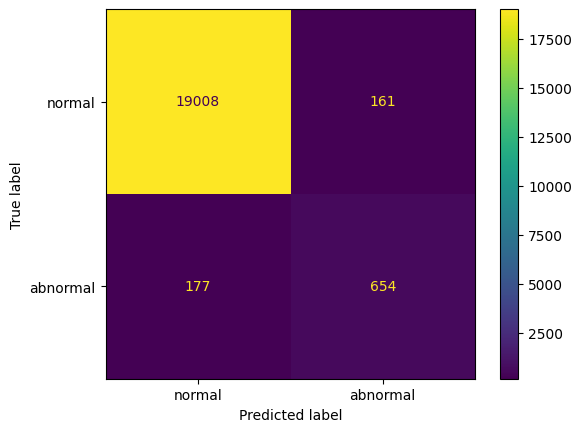

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=['normal', 'abnormal'])
disp.plot()
plt.show()

In [ ]:
# Evaluate the classifier
accuracy = accuracy_score(y_test, y_pred)
target_names = ['normal', 'abnormal']
report = classification_report(y_test, y_pred, target_names=target_names)

print(f'Accuracy: {accuracy}')
print('Classification Report:\n', report)

Accuracy: 0.9749
Classification Report:
               precision    recall  f1-score   support

      normal       0.99      0.98      0.99     19169
    abnormal       0.66      0.81      0.73       831

    accuracy                           0.97     20000
   macro avg       0.83      0.90      0.86     20000
weighted avg       0.98      0.97      0.98     20000



Let's do some naive hyperparameter tuning

In [ ]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'nu': [0.01, 0.02],  # Regularization parameter (controls the fraction of outliers)
    'kernel': ['linear', 'rbf', 'poly'],  # Kernel type
    'gamma': ['scale', 'auto']  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
    # 'gamma': ['scale', 'auto', 0.1, 1, 10]  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
}

# Initialize variables to track the best score and parameters
best_f1_score = 0
best_params = {}

# Manually iterate through parameter combinations
for nu in param_grid['nu']:
    for kernel in param_grid['kernel']:
        for gamma in param_grid['gamma']:
            # Create and train the OneClassSVM classifier
            clf = svm.OneClassSVM(nu=nu, kernel=kernel, gamma=gamma)
            clf.fit(X_train)

            # Make predictions on the test set
            y_pred = clf.predict(X_test)
            y_pred = [1 if y == -1 else 0 for y in y_pred]

            # Calculate F1-score
            f1 = f1_score(y_test, y_pred)
            # Calculate Recall
            recall = recall_score(y_test, y_pred)
            # Calculate Precision
            precision = precision_score(y_test_pd, y_pred_pd)

            # Update best score and parameters if current combination is better
            if f1 > best_f1_score:
                best_f1_score = f1
                best_params = {'nu': nu, 'kernel': kernel, 'gamma': gamma}

            print(f"Parameters: nu={nu}, kernel='{kernel}', gamma='{gamma}', Recall: {recall}, Precision: {precision}, F1-Score: {f1}")

# Print the best parameters and score
print("Best Parameters:", best_params)
print("Best F1-Score:", best_f1_score)

#### Use Novelty Detection with Local Outlier Factor

In [ ]:
# lof = neighbors.LocalOutlierFactor(novelty=True, contamination=0.3, n_neighbors=12)
lof = neighbors.LocalOutlierFactor(novelty=True, contamination='auto', n_neighbors=5)
lof.fit(X_train)

LocalOutlierFactor(n_neighbors=5, novelty=True)

In [ ]:
# Make predictions on the test set (consider outliers as the positive class)
y_pred = lof.predict(X_test)
y_pred = [1 if y == -1 else 0 for y in y_pred]  # Convert -1 (outlier) to 1

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_pred)
cnf_matrix

array([[18906,   263],
       [  125,   706]])

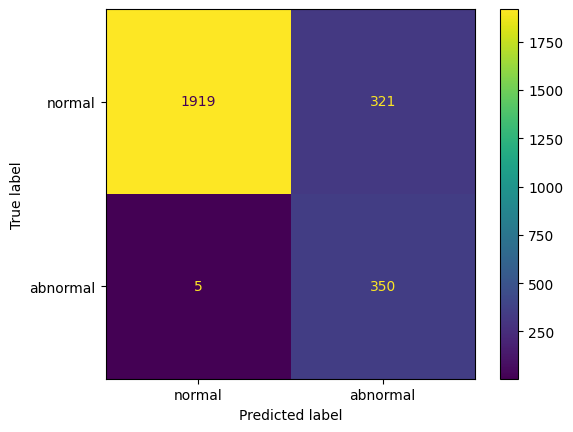

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=['normal', 'abnormal'])
disp.plot()
plt.show()

In [ ]:
# Evaluate the novel detection
accuracy = accuracy_score(y_test, y_pred)
target_names = ['normal', 'abnormal']
report = classification_report(y_test, y_pred, target_names=target_names)

print(f'Accuracy: {accuracy}')
print('Classification Report:\n', report)

Accuracy: 0.9806
Classification Report:
               precision    recall  f1-score   support

      normal       0.99      0.99      0.99     19169
    abnormal       0.73      0.85      0.78       831

    accuracy                           0.98     20000
   macro avg       0.86      0.92      0.89     20000
weighted avg       0.98      0.98      0.98     20000



Let's do some naive hyperparameter tuning

In [ ]:
# Define the parameter grid for LocalOutlierFactor (adjust values as needed)
param_grid = {
    'n_neighbors': [5, 10, 15, 20],  # Number of neighbors to consider
    'contamination': [0.01, 0.02, 0.1, 0.2, 'auto'],  # Estimated proportion of outliers in the data set
    'novelty': [True]  # Must be True for anomaly detection
}

# Initialize variables to track the best score and parameters
best_f1_score = 0
best_recall = 0
best_params = {}

# Manually iterate through parameter combinations
for n_neighbors in param_grid['n_neighbors']:
    for contamination in param_grid['contamination']:
        # Create and train the OneClassSVM classifier
        clf = neighbors.LocalOutlierFactor(novelty=True, contamination=contamination, n_neighbors=n_neighbors)
        clf.fit(X_train)

        # Make predictions on the test set
        y_pred = clf.predict(X_test)
        y_pred = [1 if y == -1 else 0 for y in y_pred]

        # Calculate F1-score
        f1 = f1_score(y_test, y_pred)
        # Calculate Recall
        recall = recall_score(y_test, y_pred)
        # Calculate Precision
        precision = precision_score(y_test, y_pred)

        # Update best score and parameters if current combination is better
        if f1 > best_f1_score:
            best_f1_score = f1
            best_params = {'n_neighbors': n_neighbors, 'contamination': contamination}

        print(f"Parameters: n_neighbors={n_neighbors}, contamination={contamination}, Recall: {recall}, Precision: {precision}, F1-Score: {f1}")

# Print the best parameters and score
print("Best Parameters:", best_params)
print("Best F1-Score:", best_recall)

## Summary

Here's the summary of the HDFS logs outlier detection you did in this notebook:

| Outlier Detection Method | Recall | Precision | F1-score |
|---|---|---|---|
| **Embeddings + BQ Vector Search** | **0.92** | **0.90** | **0.91** |
| Embeddings + LocalOutlierFactor | 0.85 | 0.73 | 0.78 |
| Embeddings + OneClassSVM | 0.81 | 0.66 | 0.73 |

These metrics show how **BigQuery vector search** can perform similar, or even better than common novelty or outlier detection algorithms. This demonstrates the robustness of its underlying native k-means clustering. These results stem from a combination of factors:

- First, Gemini 1.5 Flash effectively summarizes logs sequence including any abnormal activity.
- Second, the vector embeddings generated by the text embedding model are well suited for clustering similar normal log sequences together, capturing nuances and representing most abherrations into outliers.
- Finally, vector search offers speed and flexibility in fine-tuning distance and neighbor count parameters to optimize the balance between precision and recall.


Now, let's compare with other leading methods such as DeepLog, N-gram, IM and PCA which were evaluated on HDFS logs dataset by [DeepLog: Anomaly Detection and Diagnosis from System Logs through Deep Learning](https://dl.acm.org/doi/10.1145/3133956.3134015) paper:

| Outlier Detection Method | Recall | Precision | F1-score |
|---|---|---|---|
| DeepLog (RNN using LSTM) | 0.96 | 0.95 | 0.96 |
| N-gram | 0.96 | 0.92 | 0.94 |
| **Embeddings* + BQ Vector Search** | **0.92** | **0.90** | **0.91** |
| Invariants Mining (offline) | 0.95 | 0.88 | 0.91 |
| PCA (offline) | 0.67 | 0.98 | 0.79 |

\* Given notebook constraints, this method was evaluated using a test subset of 20k log sessions (equivalent to 400,000 log entries) as opposed to the entire HDFS dataset. This method was also evaluated without incremental updates to the index/model.



Some observations:

* Similar to N-gram and DeepLog, vector search-based outlier detection only requires a very small training set, about 1-10% of normal logs.

* Unlike N-gram and DeepLog, vector search-based outlier detection **requires neither training nor serving a custom model**. Vector search results can improve with newly ingested data (e.g. normal log entries that were false positives) without necessarily requiring model retraining, or re-indexing in the case of vector index. However, re-indexing is recommended when a large dataset is added after initial index creation, to help handle data skew.

* Unlike IM and PCA offline techniques, vector search-based outlier detection can be applied in a continuous fashion with streaming logs.

### Next steps

This notebook provides a step-by-step walkthrough of applying LLMs, vector embeddings and BigQuery vector search for anomaly detection in semi-structured logs using familiar SQL.  Use and extend this notebook to experiment with embeddings and evaluate vector search accuracy, speed and cost using the publicly available HDFS logs dataset or your own dataset.

The performance achieved with HDFS logs dataset is satisfactory and incurs much lower overhead compared to other alternatives given the use of off-the-shelf embedding and Gemini models. More exploratory work can be done to further evaluate and optimize recall, from fine-tuning the embedding model itself to optimizing the vector search-based anomaly detection logic (e.g. distance normalization, dynamic vs fixed threshold, etc.). That also includes index-time settings (e.g. `num_lists` for vector index) and search-time settings (e.g. `normalization_type`, `fraction_lists_to_search` for vector search). Results will vary depending on your dataset and your specific configurations.

## Cleaning up

In [ ]:
# Delete BigQuery dataset. Uncomment and run the command below if you want to delete the BigQuery set.
# from google.cloud import bigquery
# Do this only if the dataset is created for this demo.
# dataset = f"{PROJECT_ID}.{DATASET_ID}"
# dataset_object = bigquery.Dataset(dataset)
# client.delete_dataset(dataset_object, delete_contents=True, not_found_ok=True)
